In [2]:
# !pip install optuna
import os
import pandas as pd
import numpy as np
import random
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import optuna
from optuna import TrialPruned
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [3]:

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the CSV
csv_file = 'drive/MyDrive/updated_image_labels.csv'
data_df = pd.read_csv(csv_file)


## Preparing the dataset

In [4]:

# Dataset class
class SkinConditionDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path)

            # Convert image to RGB if it's not
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError) as e:
            print(f"Skipping file {img_name}, as it is not a valid image: {e}")
            return None

        # Ensure the labels are converted to float
        labels = self.dataframe.iloc[idx, 1:].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels, dtype=torch.float32) 

# Define image transformations with more aggressive data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop images
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for 3 channels
])


## Loading the dataset

In [5]:

# Load the dataset
img_dir = 'drive/MyDrive/images/acne_image_multi_label'

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Create datasets for train and validation
train_dataset = SkinConditionDataset(dataframe=train_df, img_dir=img_dir, transform=data_transforms)
val_dataset = SkinConditionDataset(dataframe=val_df, img_dir=img_dir, transform=data_transforms)

# Filter out None entries (skipped images)
train_dataset = [item for item in train_dataset if item is not None]
val_dataset = [item for item in val_dataset if item is not None]

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Skipping file desktop.ini, as it is not a valid image: cannot identify image file '/content/drive/MyDrive/images/acne_image_multi_label/desktop.ini'


In [6]:
# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## Initializing the model

In [7]:
# Function to initialize the model with customizable hyperparameters
def initialize_model(dropout_rate, learning_rate, weight_decay):
    model = models.resnet34(pretrained=True)
    num_classes = 5  

    # Replace the fully connected layer with dropout and customized output
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(model.fc.in_features, num_classes),
    )

    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary classification, multi-label
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization through weight decay

    return model, criterion, optimizer

## Hyperparameter Tuning

In [8]:

# Evaluation function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            if images is None:
                continue

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            preds = torch.sigmoid(outputs).round()  # For multi-label binary classification
            correct += (preds == labels).sum().item()
            total += labels.numel()

    average_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return average_loss, accuracy

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Early stopping instance
    early_stopping = EarlyStopping(patience=patience)

    # LR scheduler that reduces LR when a metric has stopped improving
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            if images is None:
                continue

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            preds = torch.sigmoid(outputs).round()  # For multi-label binary classification
            correct_train += (preds == labels).sum().item()
            total_train += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        # Validation step
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Step the LR scheduler
        scheduler.step(val_loss)

        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model




In [11]:
def reduce_dataset(dataset, percentage=0.1):
    dataset_size = len(dataset)
    reduced_size = int(dataset_size * percentage)
    indices = random.sample(range(dataset_size), reduced_size)
    return Subset(dataset, indices)

# Define the objective function for Optuna with pruning
def objective(trial):
    # Suggest values for hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    dropout = trial.suggest_uniform('dropout', 0.2, 0.6)
    batch_size = 32  # Fixed
    weight_decay = 1e-4  # Fixed value for weight decay

    # Initialize model with suggested hyperparameters
    model, criterion, optimizer = initialize_model(dropout_rate=dropout, learning_rate=lr, weight_decay=weight_decay)

    # Take only subset to find best hyperparameters
    reduced_train_dataset = reduce_dataset(train_dataset, percentage=0.1)  # Using 10% of the original dataset
    reduced_val_dataset = reduce_dataset(val_dataset, percentage=0.3)

    # DataLoader for reduced datasets
    train_loader = DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(reduced_val_dataset, batch_size=batch_size)

    # Number of epochs for hyperparameter search
    num_epochs = 5
    patience = 2  # Early stopping patience

    # Track validation loss for pruning
    val_losses = []

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate model on validation data
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        # Report intermediate results to Optuna (for pruning)
        trial.report(val_loss, epoch)

        # Prune if the trial should be stopped early
        if trial.should_prune():
            raise TrialPruned()

    # Return final validation loss as the objective metric
    return val_loss

# Define the Optuna study and run the hyperparameter search with pruning
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=7)

# Get the best hyperparameters from the study
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}, Best Validation Loss: {study.best_value:.4f}")


[I 2024-10-05 14:48:10,602] A new study created in memory with name: no-name-6ca236b5-580c-4672-ad11-af6d99f6e8fe
<ipython-input-11-c7f3ec2b41ba>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-11-c7f3ec2b41ba>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.6)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments 

Best Hyperparameters: {'lr': 1.4907468222702321e-05, 'dropout': 0.33445369828820815}, Best Validation Loss: 0.6677


## Training the final model

In [9]:

# Use the best hyperparameters and some fixed values to train the final model
best_lr = best_params['lr']
best_dropout = best_params['dropout']
best_batch_size = 32
best_weight_decay = 1e-4  

# Initialize the model with the best hyperparameters
final_model, criterion, optimizer = initialize_model(dropout_rate=best_dropout, learning_rate=best_lr, weight_decay=best_weight_decay)

# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size)

# Train the final model for 25 epochs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


def train_model_with_logging(model, criterion, optimizer, train_loader, val_loader, num_epochs=30, patience=6):
    # Early stopping instance
    early_stopping = EarlyStopping(patience=patience)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            if images is None:
                continue

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs).round()  # For multi-label binary classification
            correct_train += (preds == labels).sum().item()
            total_train += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validation step
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Step the LR scheduler
        scheduler.step(val_loss)

        # Check early stopping condition
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model

# Train the final model
final_model = train_model_with_logging(final_model, criterion, optimizer, train_loader, val_loader, num_epochs=25, patience=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 82.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch 1/25, Loss: 0.6412
Validation Loss: 0.5686, Validation Accuracy: 0.7211
Epoch 2/25, Loss: 0.4743
Validation Loss: 0.4770, Validation Accuracy: 0.7939
Epoch 3/25, Loss: 0.3628
Validation Loss: 0.4209, Validation Accuracy: 0.8176
Epoch 4/25, Loss: 0.2883
Validation Loss: 0.3851, Validation Accuracy: 0.8276
Epoch 5/25, Loss: 0.2310
Validation Loss: 0.3648, Validation Accuracy: 0.8398
Epoch 6/25, Loss: 0.1823
Validation Loss: 0.3468, Validation Accuracy: 0.8506
Epoch 7/25, Loss: 0.1373
Validation Loss: 0.3359, Validation Accuracy: 0.8490
Epoch 8/25, Loss: 0.1137
Validation Loss: 0.3269, Validation Accuracy: 0.8575
Epoch 9/25, Loss: 0.0878
Validation Loss: 0.3270, Validation Accuracy: 0.8575
Epoch 10/25, Loss: 0.0772
Validation Loss: 0.3250, Validation Accuracy: 0.8582
Epoch 11/25, Loss: 0.0628
Validation Loss: 0.3176, Validation Accuracy: 0.8605
Epoch 12/25, Loss: 0.0520
Validation Loss: 0.3125, Validation Accuracy: 0.8736
Epoch 13/25, Loss: 0.0483
Validation Loss: 0.3208, Validation

## Result Metrics and Visualizations

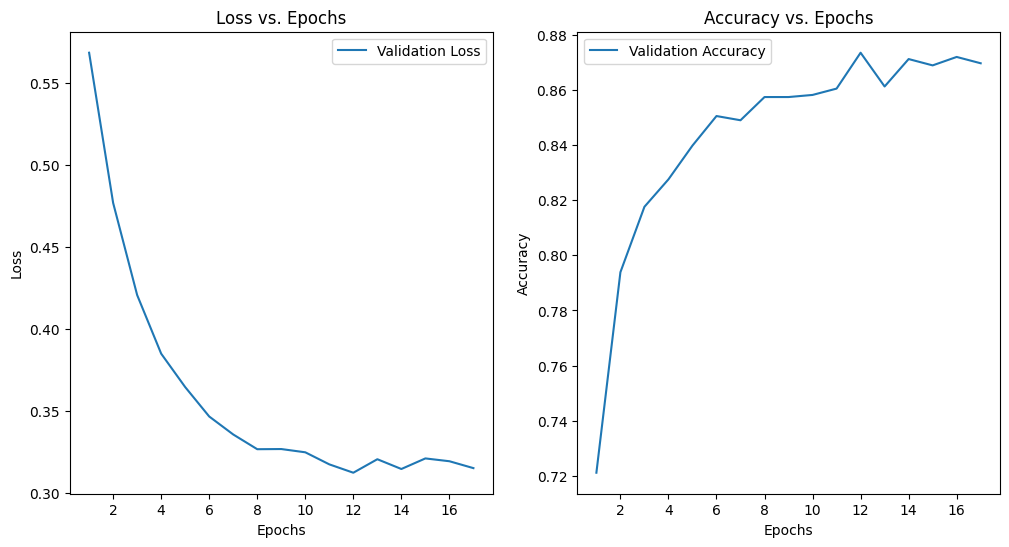

In [10]:

# Plot loss and accuracy curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

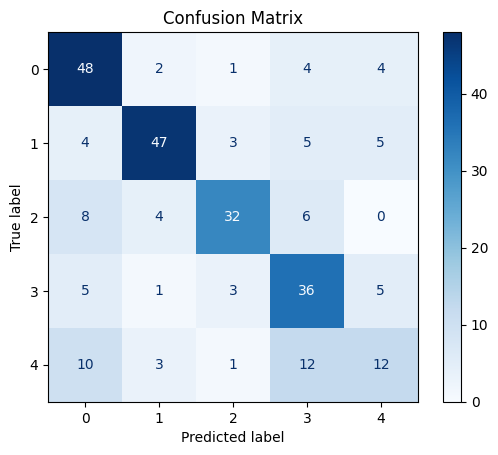

Validation Loss: 0.3153, Validation Accuracy: 0.8697, Precision: 0.7871, Recall: 0.6727, F1 Score: 0.7242


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

# Modified evaluate_model function
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Apply sigmoid to outputs for multi-label and threshold to get binary predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

            all_preds.extend(preds.cpu().numpy())  # Append binary predictions
            all_labels.extend(labels.cpu().numpy())  # Append true labels

    avg_loss = total_loss / len(data_loader)

    # Convert lists to numpy arrays for evaluation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Plotting the confusion matrix
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))  # Use argmax for multi-class confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return avg_loss, accuracy, precision, recall, f1

# Evaluation
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(final_model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
